In [26]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

# Object description

We are going to use the Hu Moments to describe and group different objects in images. In the folder called _data_ you can find a simple image with different objects.

## Load and binarize the image

The first job is to load the image and binarize it. It is important to load the image using the `cv2.IMREAD_GRAYSCALE` parameter in order to obtain a 2D matrix. Show the binarized image in order to check this part of the process.

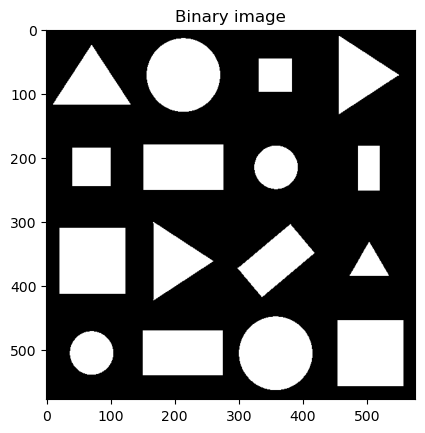

In [27]:
filename = "data/simple_shapes.png"
im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
_, bin_image = cv2.threshold(im, 254, 255, cv2.THRESH_BINARY_INV)

plt.title("Binary image")
plt.imshow(bin_image, cmap="gray")
plt.show()

## Contour detection

As you did in the segmentation assignment of the Image Analysis subject, you have to use the `findContours` function to detect all the objects in the image. In order to check if you have performed a correct detection you have to draw the contours on the image and visualize them.

_Extra_: Given a contour, you can obtain its bounding box by using the `boundingRect` function.


In [28]:
contour_img = np.zeros_like(bin_image)
contours, _ = cv2.findContours(bin_image, mode=cv2.RETR_LIST , method=cv2.CHAIN_APPROX_SIMPLE)

color = (255, 0, 0)
thickness = 2

#for contour in contours:
#    cv2.drawContours(cont_img, [contour], contourIdx=0, color=(100,100,250), thickness=1)  # Draw Interior
#    rect = cv2.boundingRect(contour)
#    start_point = (rect[0], rect[1])
#    end_point = (rect[0]+rect[2], rect[1]+rect[3])
#    image = cv2.rectangle(cont_img, start_point, end_point, color, thickness)
#plt.imshow(cont_img)
#plt.show()

## Descriptor

As we stated before, you are going to describe each object by means of the *moments*. _OpenCV_ has a built-in function for calculating Hu Moments. It is called `HuMoments` and it takes as input the central moments of the image which can be calculated using the function `moments`. The function `moments` can receive a binary image or a set of points describing a contour.

The Hu Moments obtained have a large range, so we can apply a log transform by using next code: `moment_i = -1* copysign(1.0, moment_i) * log10(abs(moment_i)))`. The `copysign` and `log10` functions are part of the _math_ library.


In [29]:

shapes = {} # Dictionary data structure 
normalization = False

for contour in contours:
    
    # Calculate Moments
    moments = cv2.moments(contour)
    huMoments = cv2.HuMoments(moments)
    
    if normalization:
        for i in range(0,7):
            if  huMoments[i] != 0.0:
                huMoments[i] = -1*math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))
            
    rect = cv2.boundingRect(contour)
    shapes[rect] = huMoments.squeeze()



## Shape matching

Now you have a descriptor for each object. Next step is to calculate the euclidean distance between the shapes and try to obtain groups of similar objects.

**This is a challenging step!!**

In [30]:
# From dictionary to numpy array
mm_moments = np.asarray(list(shapes.values()))
mm_moments.shape

(16, 7)

In [34]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=5, random_state=0).fit(mm_moments)
kmeans.labels_

centers = kmeans.cluster_centers_


C:\Users\gabri\miniconda3\envs\visio\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [35]:
# I calculate all the distances between the center of the clusters and the descriptors
distances = np.zeros((mm_moments.shape[0], len(centers)))

for i in range(mm_moments.shape[0]):
    for j in range(len(centers)):
        
        distances[i,j] = np.linalg.norm(mm_moments[i,:]-centers[j])

# Get the minimum distances
minimis = np.argmin(distances, axis=1)
print(minimis)


[0 3 0 0 1 0 3 1 0 2 0 3 0 1 0 1]


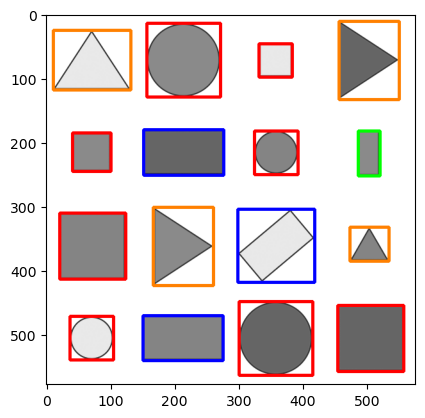

In [36]:
im2 = np.zeros((im.shape[0],im.shape[1],3))
im2[:,:,0], im2[:,:,1], im2[:,:,2] = im,im, im
im2 = im2.astype(np.uint8)
my_thickness = 4
colors = [(255,0,0),(255,128,0), (0,255,0), (0,0,255),  (0,128,255)]
for idx, shape in enumerate(shapes.keys()):
   
    start_point = (shape[0], shape[1])
    end_point = (shape[0]+shape[2], shape[1]+shape[3])
    image = cv2.rectangle(im2, start_point, end_point, colors[minimis[idx]], my_thickness)
    
plt.imshow(im2)
plt.show()